In [17]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'v1_agents_1'

base_folder = f'../../data/manager/simulate_rule/{run}'

folder = os.path.join(base_folder, 'train')
merged_folder = os.path.join(base_folder, 'merged')

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)

id_vars = ['artificial_humans', 's', 'round_number', 'n_agents', 'agent']
value_vars = ['punishments', 'common_good', 'contributions', 'payoffs']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$pun = (20-cont) \cdot s + cont? \cdot  c - b$

In [18]:
file_names = ['trace.csv']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

sim_df = get_df('trace.csv', merged_folder, folder)


In [19]:
df = sim_df.sort_values(id_vars).copy()

cum_value_vars = [f'cum_{c}' for c in value_vars]

for cum_vv, vv in zip(cum_value_vars, value_vars):
    cumsum = df.groupby(id_vars[:-1])[vv].cumsum()
    cumcount = df.groupby(id_vars[:-1])[vv].cumcount() + 1
    df[cum_vv] = cumsum / cumcount

df_melt = pd.melt(df, id_vars=id_vars, value_vars=value_vars+cum_value_vars, var_name='metric', value_name='value')

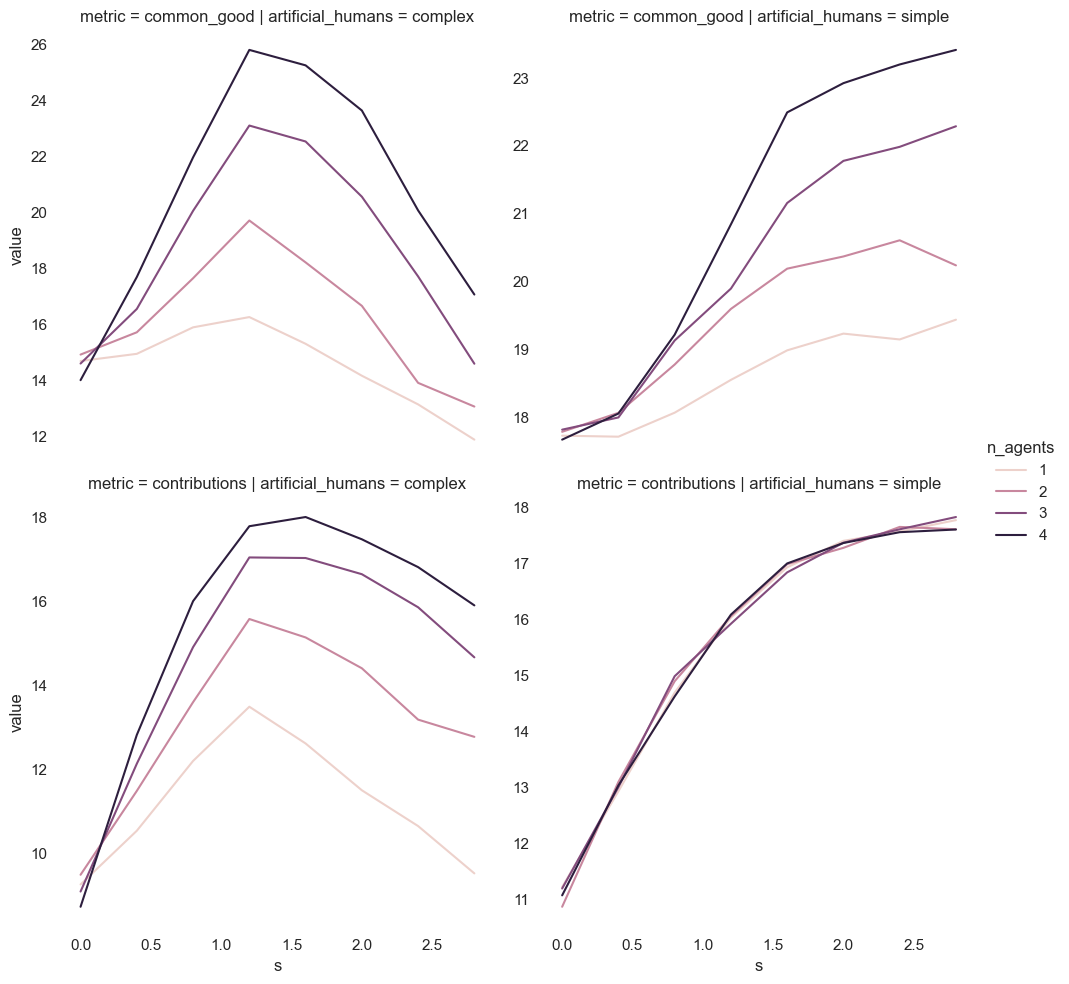

In [20]:
df = df_melt.groupby([c for c in id_vars if c != 'round_number'] + ['metric'])['value'].mean().reset_index()


w = (
    df['agent'].isin([0]) &
    df['metric'].isin(['contributions', 'common_good'])
)
df = df[w]

df[['agent', 'n_agent']] = df[['agent', 'n_agents']].astype(str)

fg = sns.relplot(data=df, x='s', y='value', hue='n_agents', col='artificial_humans', row='metric', kind='line', ci=None, facet_kws={'sharey': False, 'sharex': True})

fg.savefig(os.path.join(plot_folder, 'metric_ah.jpg'))

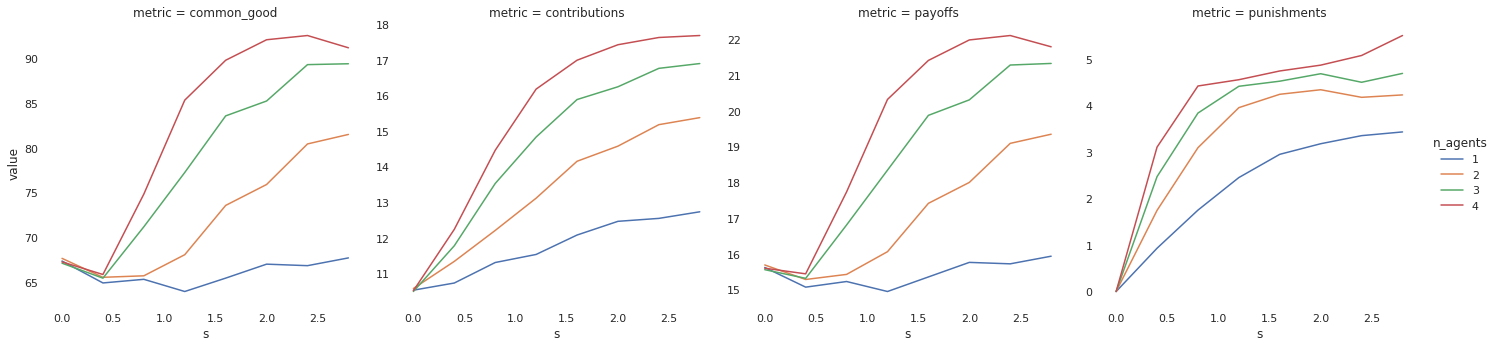

In [60]:
df = df_melt.groupby(['s', 'metric', 'n_agents'])['value'].mean().reset_index()


df['n_agents'] = df['n_agents'].astype(str)

sns.relplot(data=df, x='s', y='value', hue='n_agents', col='metric', col_wrap=4, kind='line', ci=None, facet_kws={'sharey': False, 'sharex': True})